## Regional Climatology
I created a class object that is called a [Region](#object-orientation). This object has different variables and functions associated with it. It was designed with the objective of being able to quickly and flexibly complete the following tasks:

 - Mean monthly CG [flash density](#flash-density) for a region; ~ 1km grid
 - Mean monthly [diurnal cycle](#diurnal-cycle) of CG flash density by month for a region
 - [Largest 100](#top-100) CG flash density days (12 UTC - 12 UTC) for a region
 - [JJA time (UTC) of maximum](#peak-time) CG flash density (15 minute time resolution); ~ 1 km grid
 - [“Amplitude” of the diurnal cycle](#amplitude-of-DC); 15 minute time resolution ~1km grid.  CG flash density at the time of maximum flash density - CG flash density a time of minimum flash density divided by the mean flash density. 

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn.apionly as sns
import cartopy.crs as ccrs
from cartopy.io.img_tiles import *

from scipy.ndimage.filters import gaussian_filter

%matplotlib inline

I struggled for a WHILE to find a basemap tiling service that I was happy with. There are some good options available through Mapbox, but the best plain, no label, shaded relief that I found is provided by ESRI. Check out their license before you use this tiler.

## object orientation
[Top](#Regional-Climatology) | [Region](#object-orientation) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC) | [CG amplitude](#CG-amplitude)

There are constant variables for each region so it makes sense to define a class to hold info and functions relating to the region. All the tools are generalized in the [pointprocess](http://github.com/jsignell/point-process) module

In [10]:
from pointprocess import *
import pointprocess.plotting as pplot
from lightning_setup import *

SR_LOC = os.environ.get('SR_LOC')

In [4]:
c = Region(city=cities['cedar'])
c.define_grid(nbins=600)
c.CENTER

(37.590833333333336, -112.86222222222221)

## flash density
[Top](#Regional-Climatology) | [Region](#object-orientation) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC) | [CG amplitude](#CG-amplitude)

Once you have initiated a Region, there are a bunch of options available. But first we need to grid the data. To do this, we will step month by month through all the data and make dictionaries of flash count grids for each month. 

In [5]:
%%time
MMDC_grid = {}
MMFC_grid = {}
for m in range(1,13):
    ds = c.get_ds(m=m)
    print(m)
    c.to_DC_grid(ds)
    ds.close()
    MMDC_grid.update({m: c.DC_grid})
    MMFC_grid.update({m: c.FC_grid})

1
2
3
4
5
6
7
8
9
10
11
12
CPU times: user 1min 24s, sys: 2.64 s, total: 1min 27s
Wall time: 2min 11s


### Mean Annual Flash Density

In [ ]:
%%time
MMFC = np.stack(MMFC_grid.values(), axis=0)
FC = np.sum(MMFC, axis=(0))

#annually averaged rate of occurrence of lightning
mean_annual_FD = FC/float(2016-1991)
smoothed = gaussian_filter(mean_annual_FD, 2)

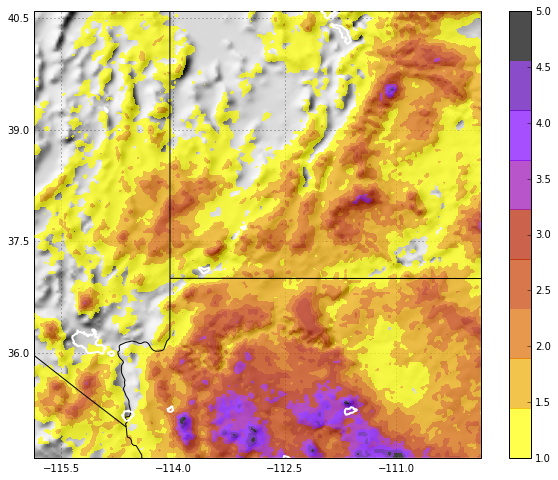

In [13]:
plt.figure(figsize=(10,8))
im, ax = c.plot_grid(smoothed, cmap=cmap, cbar=True, zorder=5.5, vmin=1, vmax=5, alpha=.7)
pplot.pre_shaded(ax, fname=SR_LOC)
pplot.urban(ax, edgecolor='white', linewidth=2)

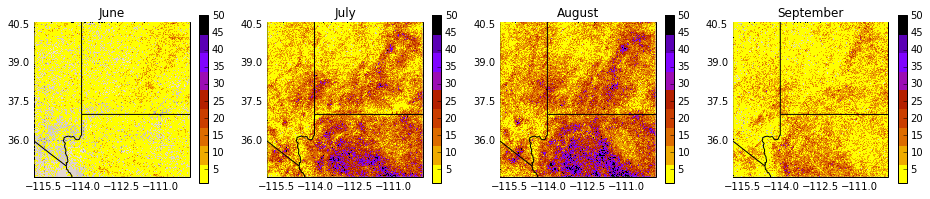

In [19]:
plt.figure(figsize=(16, 3))
n=1
for m in [6,7,8,9]:
    ax = pplot.background(plt.subplot(1, 4, n, projection=ccrs.PlateCarree()))
    c.plot_grid(MMFC_grid[m], cmap=cmap, vmin=1, vmax=50, cbar=True, ax=ax, zorder=5, alpha)
    ax.set_title(months[m])
    n+=1

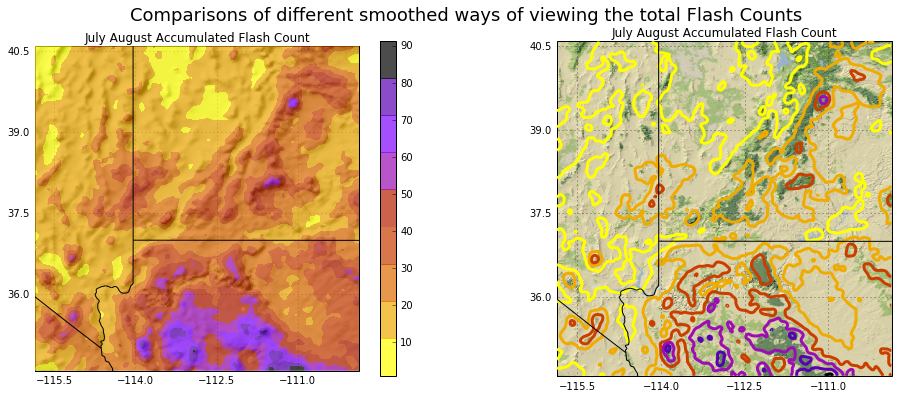

In [8]:
JAFC_grid = MMFC_grid[7]+MMFC_grid[8]
img = gaussian_filter(JAFC_grid, 4)

plt.figure(figsize=(16,6))

ax = background(plt.subplot(1, 2, 1, projection=ccrs.PlateCarree()))
im, ax = c.plot_grid(img, cmap=cmap, cbar=True, zorder=5, alpha=.7, vmin=1, ax=ax)
pre_shaded(ax, fname='/home/jsignell/data/SR_50M/SR_50M.tif')
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
ax.set_title('July August Accumulated Flash Count')

ax = background(plt.subplot(1, 2, 2,projection=ccrs.PlateCarree()))
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
ax.add_image(StamenTerrain(), 7)
ax.contour(c.gridx[:-1], c.gridy[:-1], img, cmap=cmap, zorder=5, linewidths=3)
ax.set_title('July August Accumulated Flash Count')

#plt.suptitle('Comparisons of different smoothed ways of viewing the total Flash Counts', fontsize=18);

## diurnal cycle
[Top](#Regional-Climatology) | [Region](#object-orientation) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC) | [CG amplitude](#CG-amplitude)

For now this is all based around hour of the day. This is much simpler than trying to divide the day into 15min intervals. But if we decide that we really need that capability, then we can work on it.

In [9]:
h = range(12,24)
h.extend(range(0,13))

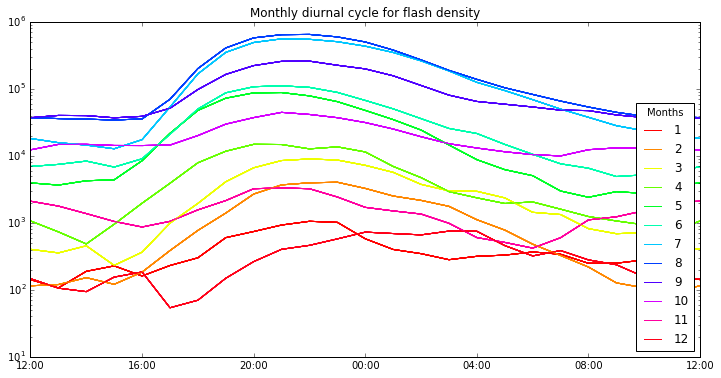

In [10]:
import matplotlib.cm as cm
h = range(12,24)
h.extend(range(0,13))

MMDC = pd.DataFrame(np.array([[np.sum(MMDC_grid[m][hr]) for hr in h] for m in months.keys()]).T)
MMDC.columns = range(1,13)

plt.figure(figsize=(12, 6))
for m in months.keys():
    ax = plt.subplot(1,1,1)
    MMDC.plot(color=cm.hsv(np.linspace(0, 1, 12)), ax=ax, title='Monthly diurnal cycle for flash density')
    plt.legend(range(1,13), title='Months', loc='lower right')
    ax.set_xticks(range(0,25,4))
    ax.set_xticklabels(['{num:02d}:00'.format(num=h[n]) for n in range(0,25,4)])
    ax.set_ylim(10**1, 10**6)
    ax.semilogy()
    ax.set_xlim(0,24)

## peak time
[Top](#Regional-Climatology) | [Region](#object-orientation) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC) | [CG amplitude](#CG-amplitude)

JJA CG flash density (Hour time resolution); ~ 10 km grid


In [11]:
JADC_grid = {}
for k,v in MMDC_grid[7].items():
    JADC_grid.update({k: v + MMDC_grid[8][k]})

In [13]:
JADC_gauss = {}
for k,v in JADC_grid.items():
    JADC_gauss.update({k:gaussian_filter(v, 4)})

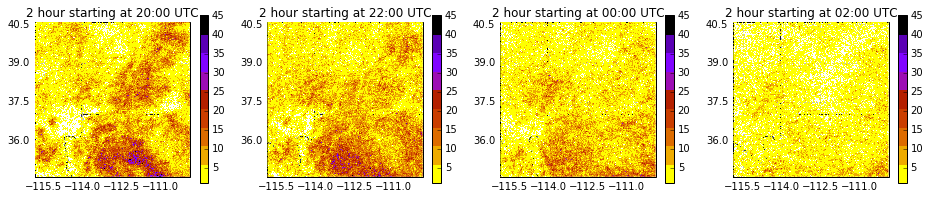

In [14]:
plt.figure(figsize=(16,3))
n=1
step = 2
for i in range(8,16,step):
    q=np.zeros(JADC_grid[0].shape)
    for hr in h[i:i+step]:
        q+=JADC_grid[hr]
    ax = background(plt.subplot(1, 4, n, projection=ccrs.PlateCarree()))
    ax.set_title('{step} hour starting at {t:02d}:00 UTC'.format(step=step, t=h[i]))
    c.plot_grid(q,cmap=cmap, vmin=1, vmax=45, cbar=True, ax=ax, zorder=10)
    n+=1

To plot the hour of peak, we need a circular colormap

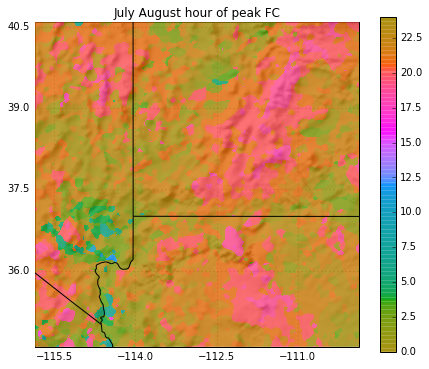

In [17]:
plt.figure(figsize=(16,6))

cmap_husl = mpl.colors.ListedColormap(sns.husl_palette(256, .2, l=.6, s=1))
img = np.argmax(np.stack(JADC_gauss.values()), axis=0)

ax = background(plt.subplot(1, 2, 2, projection=ccrs.PlateCarree()))
im, ax = c.plot_grid(img, cmap=cmap_husl, vmin=0, vmax=24, cbar=True, alpha=.8, ax=ax, zorder=5)
pre_shaded(ax, fname='/home/jsignell/data/SR_50M/SR_50M.tif')
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
ax.set_title('July August hour of peak FC');

plt.savefig('output/cedar/JA hour of peak FC.png')

## amplitude of DC
[Top](#Regional-Climatology) | [Region](#object-orientation) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC) | [CG amplitude](#CG-amplitude)

 - “Amplitude” of the diurnal cycle; 1 hour time resolution ~1km grid.  CG flash density at the time of maximum flash density - CG flash density a time of minimum flash density divided by the mean flash density. 

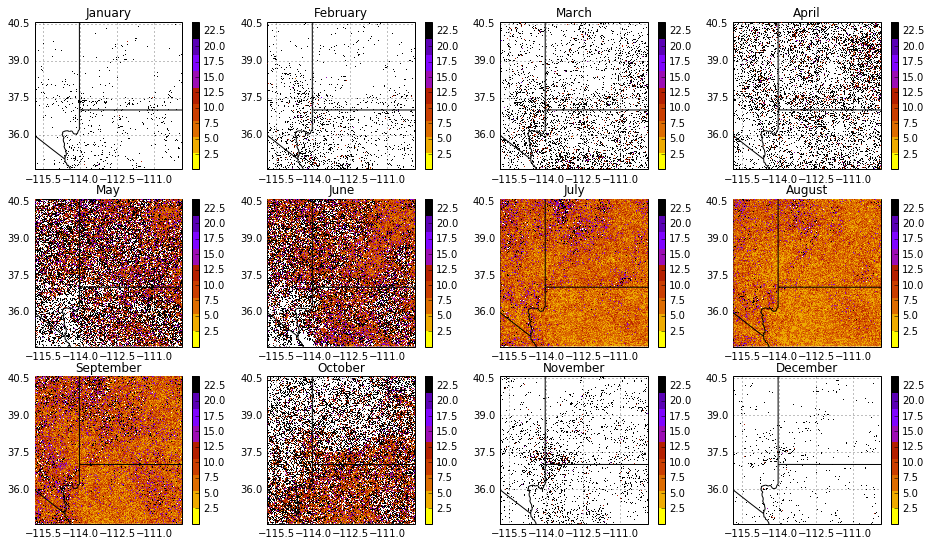

In [18]:
plt.figure(figsize=(16, 9))
for m in months.keys():
    ax = background(plt.subplot(3, 4, m, projection=ccrs.PlateCarree()))
    hourly3D = np.stack(MMDC_grid[m].values())
    amplitude = ((np.max(hourly3D, axis=0)-np.min(hourly3D, axis=0))/np.mean(hourly3D, axis=0))
    amplitude = np.nan_to_num(amplitude)
    c.plot_grid(amplitude, cmap=cmap, cbar=True, vmin=.0001, ax=ax)
    ax.set_title(months[m])

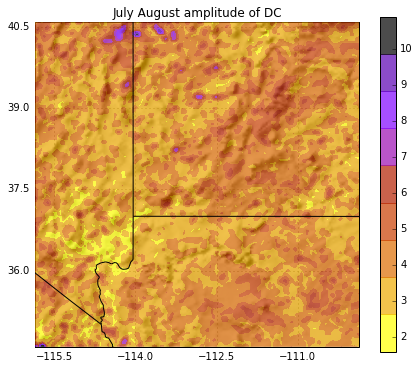

In [20]:
plt.figure(figsize=(16,6))

hourly3D = np.stack(np.stack(JADC_gauss.values()))
amplitude = ((np.max(hourly3D, axis=0)-np.min(hourly3D, axis=0))/np.mean(hourly3D, axis=0))
amplitude = np.nan_to_num(amplitude)
ax = background(plt.subplot(1, 2, 1, projection=ccrs.PlateCarree()))
im, ax = c.plot_grid(amplitude, cmap=cmap, cbar=True, ax=ax, zorder=5, alpha=.7)
pre_shaded(ax, fname='/home/jsignell/data/SR_50M/SR_50M.tif')
ax.set_extent([c.gridx.min(), c.gridx.max(), c.gridy.min(), c.gridy.max()])
ax.set_title('July August amplitude of DC');

## top 100
[Top](#Regional-Climatology) | [Region](#object-orientation) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC) | [CG amplitude](#CG-amplitude)

This function is kind of dirty because it uses filesize as a first pass proxy for FC. 

In [21]:
top10 = c.get_top(10)
top10

2014-09-26 12:00:00    91884
2014-09-27 12:00:00    90627
2015-08-30 12:00:00    66916
2014-08-12 12:00:00    65613
2015-07-08 12:00:00    63068
2015-07-01 12:00:00    62599
2013-08-17 12:00:00    62191
2014-08-26 12:00:00    58833
2014-07-15 12:00:00    50065
2015-08-07 12:00:00    48051
dtype: int64

## CG amplitude
[Top](#Regional-Climatology) | [Region](#object-orientation) | [flash density](#flash-density) | [diurnal cycle](#diurnal-cycle) | [Largest 100](#top-100) | [peak](#peak-time) | [amplitude diurnal cycle](#amplitude-of-DC) | [CG amplitude](#CG-amplitude)

In [22]:
ds = xr.open_mfdataset(c.PATH+'2012_*_*.nc')
df = ds.to_dataframe()
ds.close()

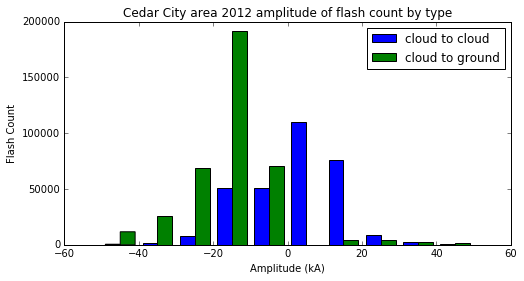

In [24]:
plt.figure(figsize=(8,4))
plt.hist([df[df['cloud_ground'] == 'C']['amplitude'],df[df['cloud_ground'] == 'G']['amplitude']], 
         bins=10, range=(-50, 50))
plt.ylabel('Flash Count')
plt.title('Cedar City area 2012 amplitude of flash count by type')
plt.xlabel('Amplitude (kA)')
plt.legend(labels=['cloud to cloud', 'cloud to ground']);